# Visualize sample output for unsupervised model with MSE loss 

In [48]:
moving_image_file = r'D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0384_MR1/slice_norm.nii.gz'
fixed_image_file  = r'D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0401_MR1/slice_norm.nii.gz'

In [49]:
moving_seg_file = r"D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0384_MR1/slice_seg4.nii.gz"
fixed_seg_file  = r"D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0401_MR1/slice_seg4.nii.gz"

In [50]:
!python ../scripts/register.py --moving D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0384_MR1/slice_norm.nii.gz --fixed D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0401_MR1/slice_norm.nii.gz --model ../models_mse_us_scan/0000.h5 --moved ./output/moved_us_mse.nii.gz --warp ./output/warp_us_mse.nii.gz


1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 0s 229ms/step


2025-12-02 17:11:54.698747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-12-02 17:11:54.699000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-02 17:12:00.202802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2025-12-02 17:12:00.203365: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-02 17:12:00.208534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: MSI
2025-12-02 17:12:00.208972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: MSI
2025-12-02 17:12:00.209526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D

In [51]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import neurite as ne 


In [52]:
file_path = "./output/moved_us_mse.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()
header = img.header
print(f"--- File: {file_path} ---")
print("Shape:", data.shape)
print("Data type:", data.dtype)
print("Voxel size (mm):", header.get_zooms())
print("Min value:", np.min(data))
print("Max value:", np.max(data))
print("Mean value:", np.mean(data))
print("\n")

--- File: ./output/moved_us_mse.nii.gz ---
Shape: (160, 192)
Data type: float64
Voxel size (mm): (1.0, 1.0)
Min value: 0.0
Max value: 0.847058892250061
Mean value: 0.1395042814571056




In [53]:
file_path = "./output/warp_us_mse.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()
header = img.header
print(f"--- File: {file_path} ---")
print("Shape:", data.shape)
print("Data type:", data.dtype)
print("Voxel size (mm):", header.get_zooms())
print("Min value:", np.min(data))
print("Max value:", np.max(data))
print("Mean value:", np.mean(data))
print("\n")

--- File: ./output/warp_us_mse.nii.gz ---
Shape: (160, 192, 2)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: -7.319238648051396e-05
Max value: 2.7319467335473746e-05
Mean value: -1.228001901784722e-05




In [54]:
def load_nii(path):
    return nib.load(path).get_fdata()

def rotate_img(img):
    return np.rot90(img, k=-1)  # Xoay -90 độ

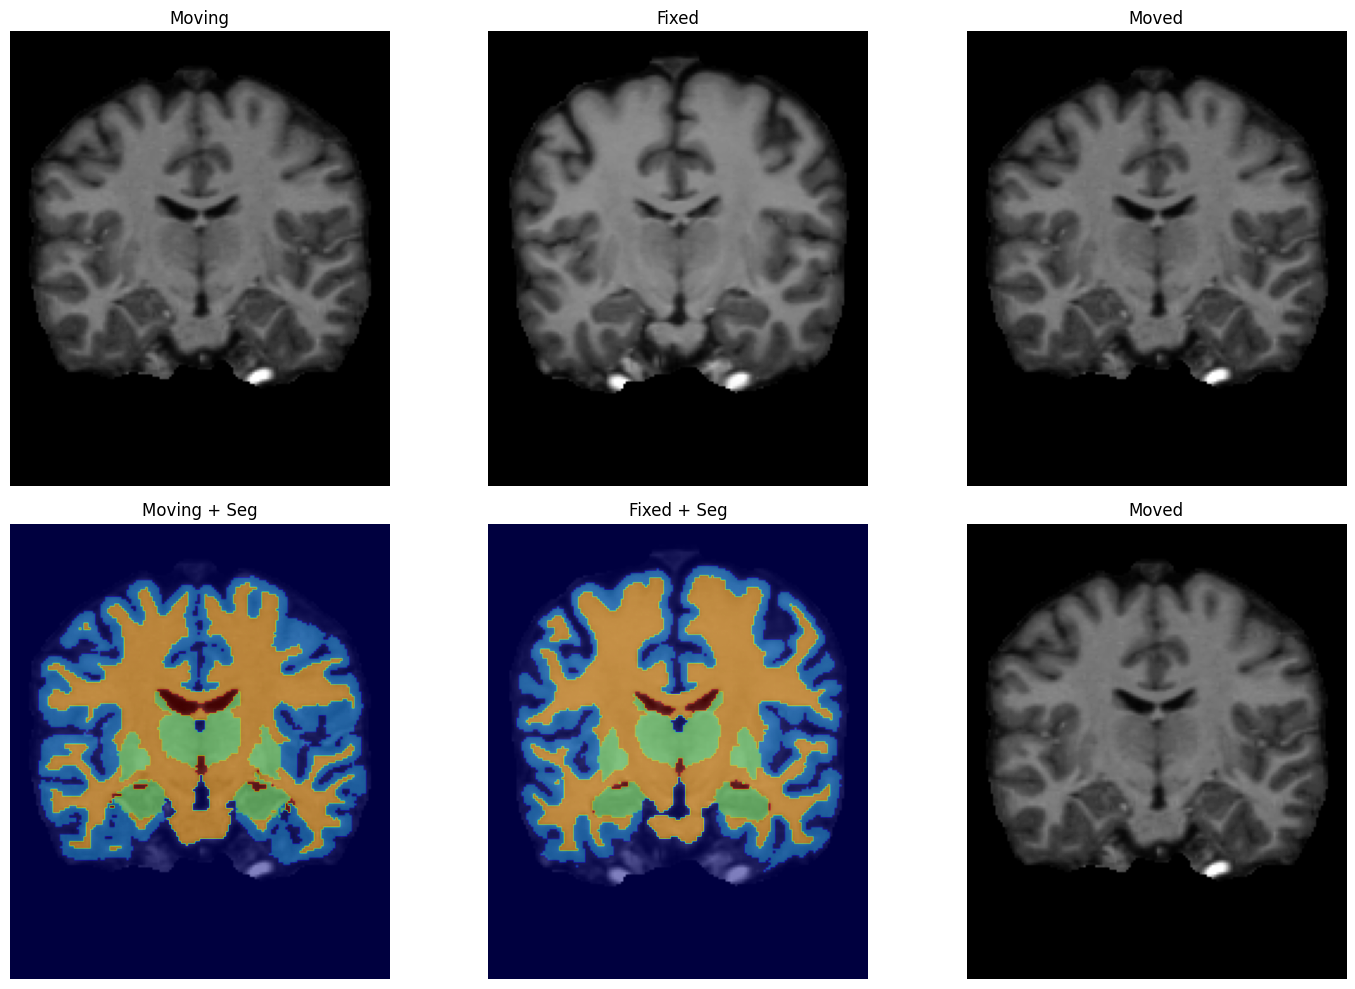

In [55]:
# Load images
moving = rotate_img(load_nii(moving_image_file)[:,:,0])
fixed  = rotate_img(load_nii(fixed_image_file)[:,:,0])
moved  = rotate_img(load_nii('./output/moved_us_mse.nii.gz')[:,:])

moving_seg = rotate_img(load_nii(moving_seg_file)[:,:,0])
fixed_seg  = rotate_img(load_nii(fixed_seg_file)[:,:,0])

# Load deformation field (HxWx2) và xoay từng kênh
flow = load_nii('./output/warp_us_mse.nii.gz')
flow_rot = np.stack([rotate_img(flow[...,0]), rotate_img(flow[...,1])], axis=-1)

# Visualize images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(moving, cmap='gray'); axes[0,0].set_title('Moving'); axes[0,0].axis('off')
axes[0,1].imshow(fixed, cmap='gray'); axes[0,1].set_title('Fixed'); axes[0,1].axis('off')
axes[0,2].imshow(moved, cmap='gray'); axes[0,2].set_title('Moved'); axes[0,2].axis('off')

axes[1,0].imshow(moving, cmap='gray'); axes[1,0].imshow(moving_seg, cmap='jet', alpha=0.5); axes[1,0].set_title('Moving + Seg'); axes[1,0].axis('off')
axes[1,1].imshow(fixed, cmap='gray'); axes[1,1].imshow(fixed_seg, cmap='jet', alpha=0.5); axes[1,1].set_title('Fixed + Seg'); axes[1,1].axis('off')
axes[1,2].imshow(moved, cmap='gray'); axes[1,2].set_title('Moved'); axes[1,2].axis('off')

plt.tight_layout()
plt.show()

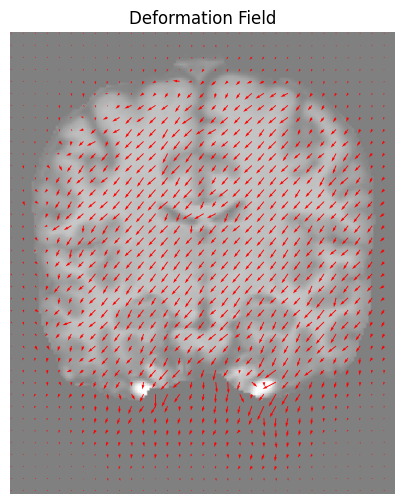

In [56]:
# Visualize deformation field
H, W = flow_rot.shape[:2]
Y, X = np.mgrid[0:H:5, 0:W:5]
U = flow_rot[::5, ::5, 0]
V = flow_rot[::5, ::5, 1]

plt.figure(figsize=(6,6))
plt.imshow(fixed, cmap='gray', alpha=0.5)
plt.quiver(X, Y, U, V, color='r')
plt.title('Deformation Field')
plt.axis('off')
plt.show()


# Visualize sample output for unsupervised model with NCC loss 

In [57]:
!python ../scripts/register.py --moving D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0384_MR1/slice_norm.nii.gz --fixed D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0401_MR1/slice_norm.nii.gz --model ../models_ncc_us_scan/0000.h5 --moved ./output/moved_us_ncc.nii.gz --warp ./output/warp_us_ncc.nii.gz


1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 0s 193ms/step


2025-12-02 17:12:08.981309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-12-02 17:12:08.981707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-02 17:12:14.020944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2025-12-02 17:12:14.021149: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-02 17:12:14.025003: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: MSI
2025-12-02 17:12:14.025213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: MSI
2025-12-02 17:12:14.025760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D

In [58]:
file_path = "./output/moved_us_ncc.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()
header = img.header
print(f"--- File: {file_path} ---")
print("Shape:", data.shape)
print("Data type:", data.dtype)
print("Voxel size (mm):", header.get_zooms())
print("Min value:", np.min(data))
print("Max value:", np.max(data))
print("Mean value:", np.mean(data))
print("\n")

--- File: ./output/moved_us_ncc.nii.gz ---
Shape: (160, 192)
Data type: float64
Voxel size (mm): (1.0, 1.0)
Min value: 0.0
Max value: 0.8470588326454163
Mean value: 0.13950425180326667




In [59]:
file_path = "./output/warp_us_ncc.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()
header = img.header
print(f"--- File: {file_path} ---")
print("Shape:", data.shape)
print("Data type:", data.dtype)
print("Voxel size (mm):", header.get_zooms())
print("Min value:", np.min(data))
print("Max value:", np.max(data))
print("Mean value:", np.mean(data))
print("\n")

--- File: ./output/warp_us_ncc.nii.gz ---
Shape: (160, 192, 2)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: -0.0001944894902408123
Max value: 1.47035798363504e-05
Mean value: -5.239764705006019e-05




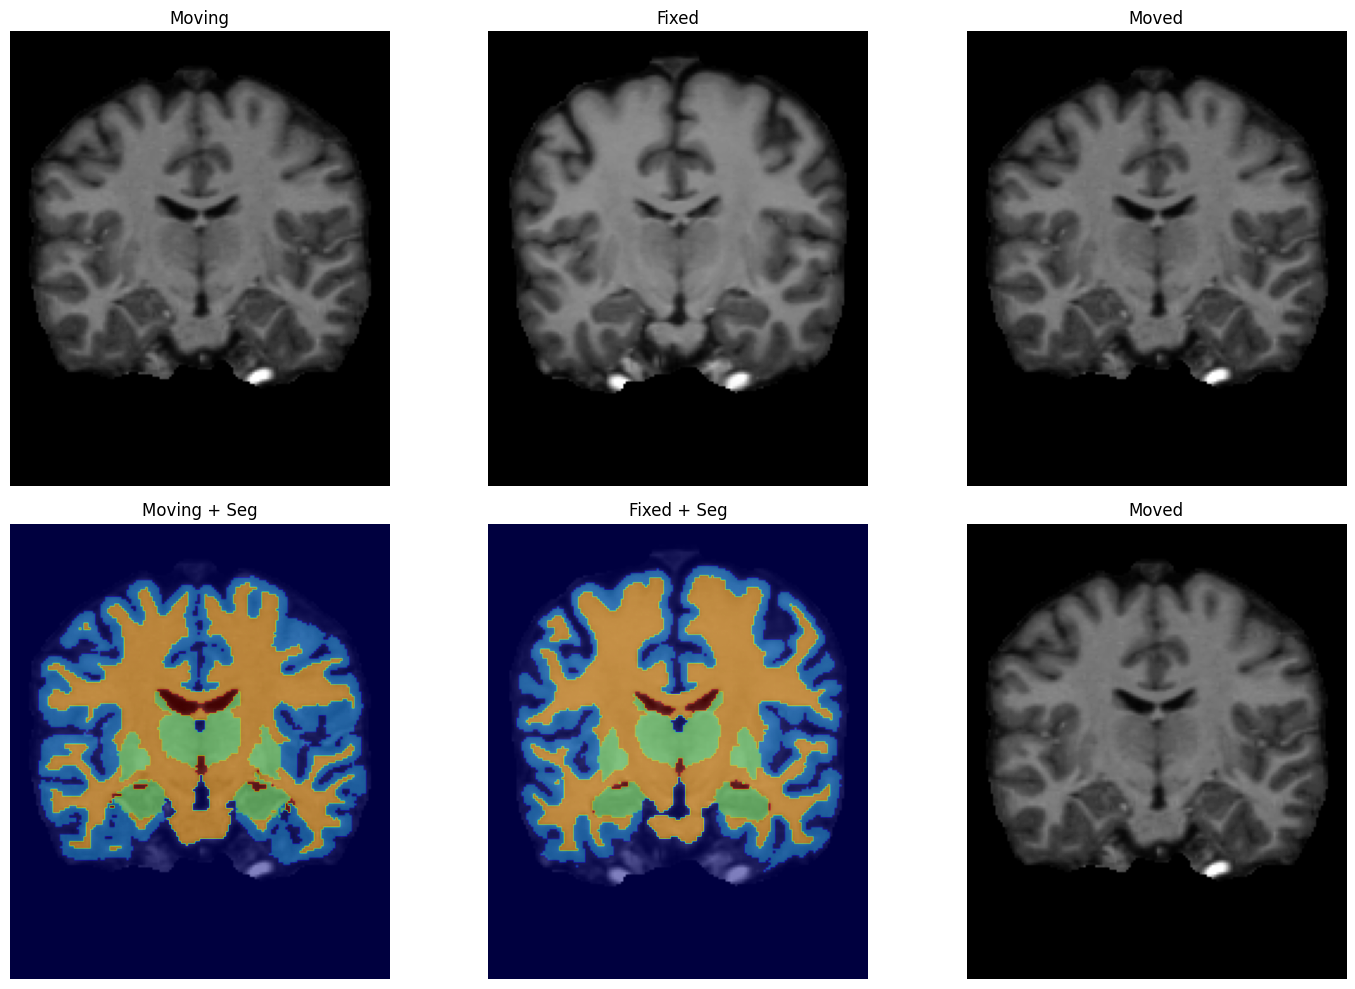

In [60]:
# Load images
moving = rotate_img(load_nii(moving_image_file)[:,:,0])
fixed  = rotate_img(load_nii(fixed_image_file)[:,:,0])
moved  = rotate_img(load_nii('./output/moved_us_ncc.nii.gz')[:,:])

moving_seg = rotate_img(load_nii(moving_seg_file)[:,:,0])
fixed_seg  = rotate_img(load_nii(fixed_seg_file)[:,:,0])
# Load deformation field (HxWx2) và xoay từng kênh
flow = load_nii('./output/warp_us_ncc.nii.gz')
flow_rot = np.stack([rotate_img(flow[...,0]), rotate_img(flow[...,1])], axis=-1)

# Visualize images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(moving, cmap='gray'); axes[0,0].set_title('Moving'); axes[0,0].axis('off')
axes[0,1].imshow(fixed, cmap='gray'); axes[0,1].set_title('Fixed'); axes[0,1].axis('off')
axes[0,2].imshow(moved, cmap='gray'); axes[0,2].set_title('Moved'); axes[0,2].axis('off')

axes[1,0].imshow(moving, cmap='gray'); axes[1,0].imshow(moving_seg, cmap='jet', alpha=0.5); axes[1,0].set_title('Moving + Seg'); axes[1,0].axis('off')
axes[1,1].imshow(fixed, cmap='gray'); axes[1,1].imshow(fixed_seg, cmap='jet', alpha=0.5); axes[1,1].set_title('Fixed + Seg'); axes[1,1].axis('off')
axes[1,2].imshow(moved, cmap='gray'); axes[1,2].set_title('Moved'); axes[1,2].axis('off')

plt.tight_layout()
plt.show()


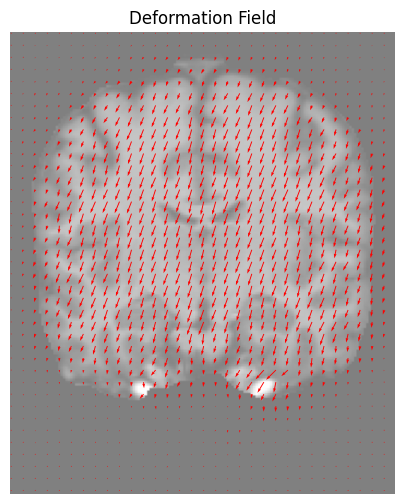

In [61]:
# Visualize deformation field
H, W = flow_rot.shape[:2]
Y, X = np.mgrid[0:H:5, 0:W:5]
U = flow_rot[::5, ::5, 0]
V = flow_rot[::5, ::5, 1]

plt.figure(figsize=(6,6))
plt.imshow(fixed, cmap='gray', alpha=0.5)
plt.quiver(X, Y, U, V, color='r')
plt.title('Deformation Field')
plt.axis('off')
plt.show()
